# Imports and Preparing the data of behavior.tsv and news.tsv #

In [1]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import re
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import IncrementalPCA, PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage


# Load the data
base_path = Path.cwd() / 'data'
news_path = base_path / 'news.tsv'
behaviors_path = base_path / 'behaviors.tsv'

news = pd.read_csv(news_path, sep='\t', names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
behaviors = pd.read_csv(behaviors_path, sep='\t', names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

# Preprocessing with Data Cleaning Remove duplicates and Text cleaning

In [2]:
# Data Cleaning
# Check if attributes such as Category, Subcategory, Title, and Abstract in news.tsv are complete.
# Remove news items with many missing values or replace them with:
# Category: unknown
# Subcategory: general
# Title and Abstract: a placeholder text like "Missing Data."
# For behaviors.tsv, remove users with missing or empty history.
news.fillna({'category': 'unknown', 'subcategory': 'general', 'title': 'Missing Title', 'abstract': 'Missing Abstract'}, inplace=True)
news.dropna(subset=['category', 'subcategory', 'title', 'abstract'], inplace=True)
behaviors.dropna(subset=['history', 'impressions'], inplace=True)

# Remove duplicates
# Remove news items in news.tsv that have the same values for Title and Abstract.
# Remove duplicate impressions (Impression ID) in behaviors.tsv
news.drop_duplicates(subset=['title', 'abstract'], inplace=True)
behaviors.drop_duplicates(subset=['impression_id'], inplace=True)

# Text cleaning
# Break down Title and Abstract into tokens:
# Remove special characters, numbers, and HTML.
# Convert all words to lowercase.
# Remove stopwords (e.g., using nltk or spacy).
# Perform lemmatization to reduce words to their base form.
def clean_text(text):
    # Clean text by removing special characters, numbers, and converting to lowercase
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'s", " is", text)
    
    # Remove special characters
    text = re.sub(r'\W+', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text.lower()

def remove_stopwords_and_lemmatize(text):
    # Remove stopwords and perform basic stemming/lemmatization
    stopwords = set([
        'the', 'and', 'is', 'in', 'to', 'of', 'a', 'an', 'on', 'for', 'with', 'as', 'by', 'at', 'from', 'this',
        'that', 'it', 'or', 'but', 'not', 'be', 'are', 'was', 'were', 'can', 'will', 'would', 'should', 'has', 'have',
        'had', 'do', 'does', 'did', 'which', 'if', 'then', 'than', 'so', 'such', 'there', 'about', 'into', 'over',
        'after'
    ])

    def advanced_lemmatization(word):
        # Remove common suffixes like 'ed', 'ing', 'es', 'er', 'ly'
        suffixes = ['ed', 'ing', 'es', 'er', 'ly', 'able', 'ness']
        for suffix in suffixes:
            if word.endswith(suffix):
                return word[:-len(suffix)]
        return word

    # List of simple verbs
    irregular_verbs = {
        'ran': 'run',
        'ate': 'eat',
        'wrote': 'write',
        'went': 'go',
        'saw': 'see',
        'had': 'have',
        'was': 'be',
        'were': 'be'
    }

    def lemmatize_irregular_verbs(word):
        # Lemmatisiere unregelmäßige Verben
        return irregular_verbs.get(word, word)

    words = text.split()
    lemmatized = []

    for word in words:
        # Outsort verbs
        word = lemmatize_irregular_verbs(word)
        # Remove suffix
        word = advanced_lemmatization(word)
        lemmatized.append(word)

    return " ".join(word for word in lemmatized if word not in stopwords)

def preprocess_text(text):
    # Full preprocessing pipeline: clean text, remove stopwords, and lemmatize
    cleaned_text = clean_text(text)
    return remove_stopwords_and_lemmatize(cleaned_text)


def preprocess_text_parallel(texts):
    processed_texts = [preprocess_text(text) for text in texts]
    return processed_texts


# Clean Title and Abstract
news['clean_title'] = preprocess_text_parallel(news['title'])
news['clean_abstract'] = preprocess_text_parallel(news['abstract'])

# Data Preparation with TF-IDF, One-hot and PCA

In [3]:
#TF-IDF
# Convert clean_title and clean_abstract into numerical vectors
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_title = tfidf_vectorizer.fit_transform(news['clean_title'])
tfidf_abstract = tfidf_vectorizer.fit_transform(news['clean_abstract'])

# Combine sparse matrices
news_features = hstack([tfidf_title, tfidf_abstract])

# One-hot encode categories and subcategories
category_encoded = pd.get_dummies(news['category'])
subcategory_encoded = pd.get_dummies(news['subcategory'])

# Combine categorical and TF-IDF features
final_features = hstack([news_features, category_encoded.values, subcategory_encoded.values])

# PCA for faster processing instead of t-SNE for better visualization
pca = IncrementalPCA(n_components=50, batch_size=1000)
reduced_features = pca.fit_transform(news_features)

# Elbow method to get best cluster amount

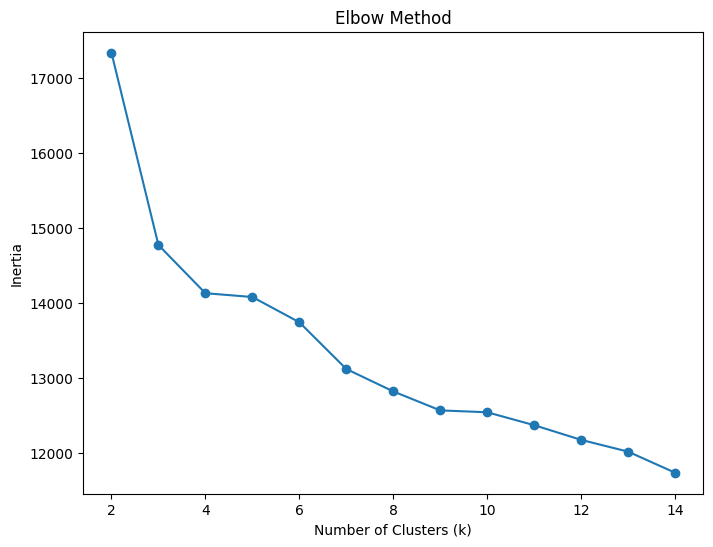

In [4]:
# Elbow method
inertia_values = []
cluster_range = range(2, 15)  # Test cluster numbers between 2 and 14

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_features)
    inertia_values.append(kmeans.inertia_)

# Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [5]:
elbow_k = cluster_range[np.diff(np.sign(np.diff(inertia_values))).argmax() + 1]
print(f"Optimal number of clusters from Elbow method: {elbow_k}")

Optimal number of clusters from Elbow method: 3


# Silhouette analysis to get best cluster amount

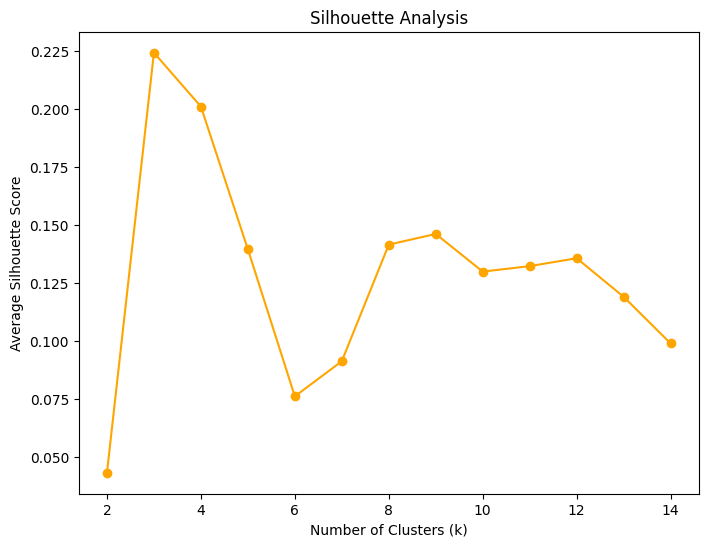

In [6]:
# Silhouette analysis
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced_features)
    silhouette_avg = silhouette_score(reduced_features, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

In [7]:
# Print the best k according to silhouette score
optimal_k_silhouette = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters from Silhouette method: {optimal_k_silhouette}")

# Print average silhouette score for each k
for k, score in zip(cluster_range, silhouette_scores):
    print(f"Number of clusters: {k}, Average Silhouette Score: {score:.4f}")

Optimal number of clusters from Silhouette method: 3
Number of clusters: 2, Average Silhouette Score: 0.0433
Number of clusters: 3, Average Silhouette Score: 0.2243
Number of clusters: 4, Average Silhouette Score: 0.2011
Number of clusters: 5, Average Silhouette Score: 0.1396
Number of clusters: 6, Average Silhouette Score: 0.0762
Number of clusters: 7, Average Silhouette Score: 0.0914
Number of clusters: 8, Average Silhouette Score: 0.1416
Number of clusters: 9, Average Silhouette Score: 0.1462
Number of clusters: 10, Average Silhouette Score: 0.1300
Number of clusters: 11, Average Silhouette Score: 0.1323
Number of clusters: 12, Average Silhouette Score: 0.1358
Number of clusters: 13, Average Silhouette Score: 0.1191
Number of clusters: 14, Average Silhouette Score: 0.0991


# Hierarchical Clustering with Dendrogram

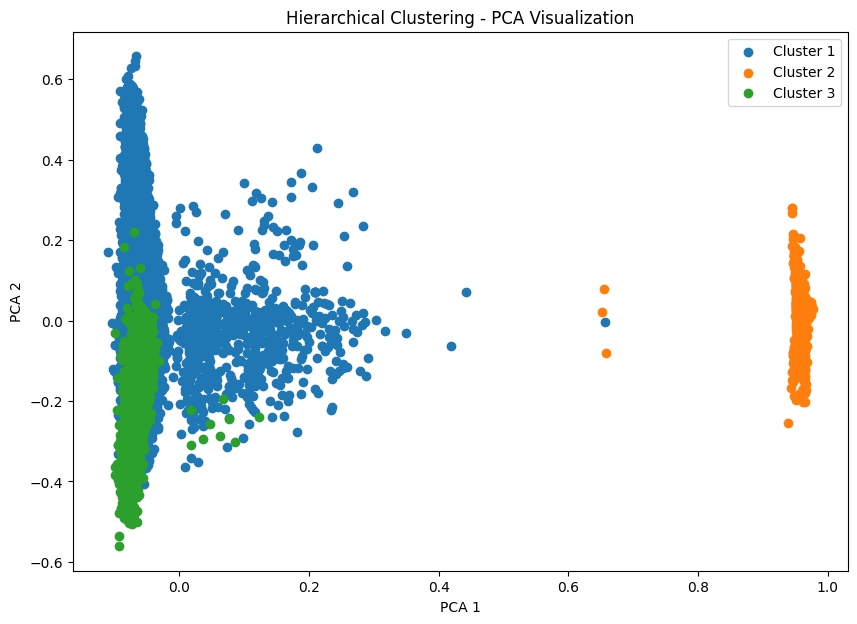

In [8]:
# Optimal value for k
optimal_k = 3

# Perform Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels = agglo.fit_predict(reduced_features)

# PCA for visualizing the clusters
pca_vis = PCA(n_components=2)
pca_features = pca_vis.fit_transform(reduced_features)

# Visualizing the clusters in the PCA space
plt.figure(figsize=(10, 7))
for i in range(optimal_k):
    # Plot points from each cluster in the PCA space with different colors
    plt.scatter(pca_features[labels == i, 0], pca_features[labels == i, 1], label=f'Cluster {i+1}')
    
plt.title('Hierarchical Clustering - PCA Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

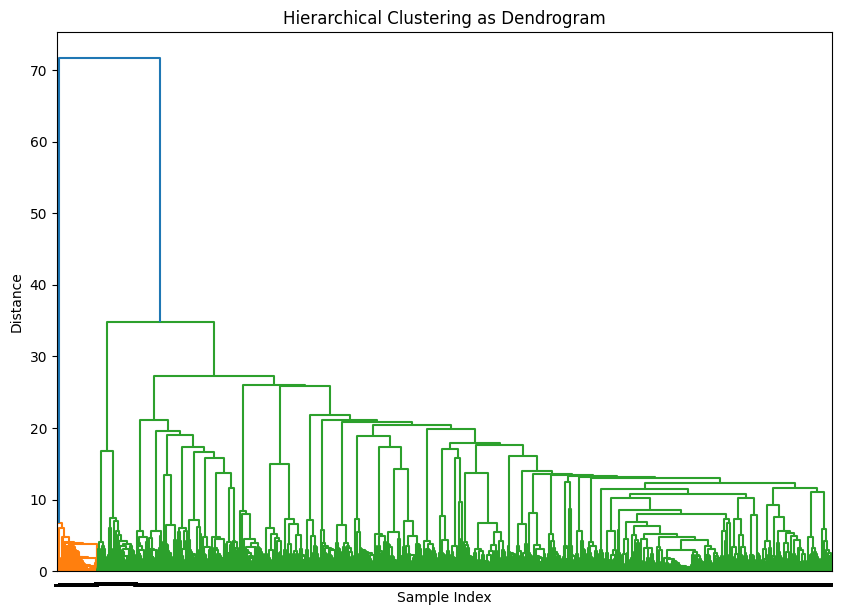

In [9]:
# Visualizing the dendrogram
Z = linkage(reduced_features, 'ward')

# Plotting the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=labels)
plt.title('Hierarchical Clustering as Dendrogram')
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# KMeans Visualization with PCA

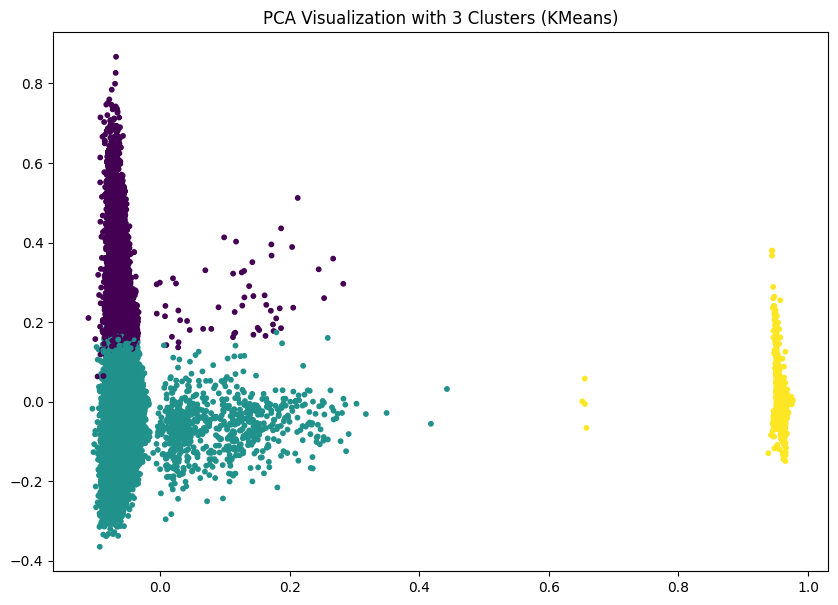

In [10]:
# Clustering with KMeans
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
news['cluster'] = kmeans.fit_predict(reduced_features)

# PCA for Visualization
pca_vis = IncrementalPCA(n_components=2)
pca_features = pca_vis.fit_transform(reduced_features)

# PCA Visualization
plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=news['cluster'], cmap='viridis', s=10)
plt.title(f'PCA Visualization with {optimal_k} Clusters (KMeans)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


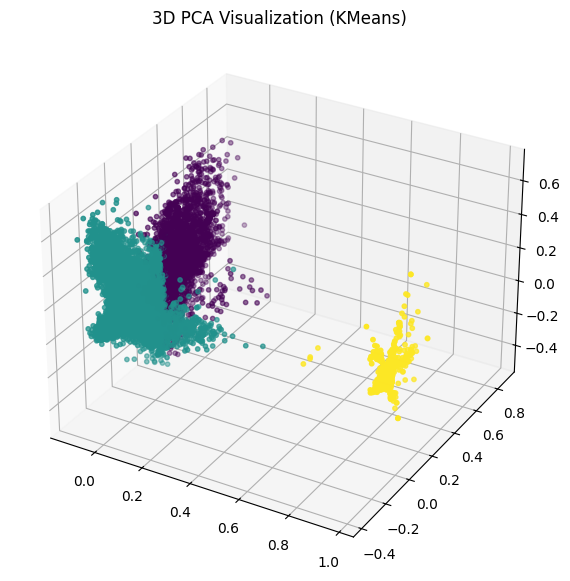

In [11]:
# PCA mit 3 Dimensionen
pca_3d = IncrementalPCA(n_components=3)
pca_features_3d = pca_3d.fit_transform(reduced_features)

# 3D-Visualisierung
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_features_3d[:, 0], 
    pca_features_3d[:, 1], 
    pca_features_3d[:, 2], 
    c=news['cluster'], cmap='viridis', s=10
)

ax.set_title('3D PCA Visualization (KMeans)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()


In [12]:
# Print KMeans cluster centers
print("KMeans Cluster Centers:")
print(kmeans.cluster_centers_)

# Print size of each cluster
print("\nCluster Sizes:")
for i in range(optimal_k):
    print(f"Cluster {i}: {sum(news['cluster'] == i)} points")

# Print inertia (sum of squared distances from samples to their cluster center)
print("\nInertia (Within-cluster sum of squares):")
print(kmeans.inertia_)

# Print explained variance ratio for the PCA components
print("\nExplained Variance Ratio by PCA Components:")
print(pca_vis.explained_variance_ratio_)

KMeans Cluster Centers:
[[-5.98902718e-02  2.60717537e-01  4.48761296e-02  1.66282941e-01
  -2.10720788e-02  4.60139076e-02  2.34412538e-02  2.00110378e-02
   3.51159388e-02  9.15322973e-04  1.45951136e-02  2.67495635e-02
  -1.34971485e-02  1.41616304e-02 -1.07146160e-02 -2.17530149e-03
  -2.06840789e-02  7.55312956e-03  3.08880013e-03 -2.78293653e-03
   1.34451746e-02  1.36106015e-02 -3.37920266e-03  5.85127051e-03
  -1.24197315e-03 -5.67806465e-03 -6.86019129e-03  5.64657467e-04
  -8.32450365e-04  8.00217218e-04 -7.20405339e-03  2.30891075e-03
  -2.99072303e-03  2.91174493e-03 -3.79925102e-03 -2.29722372e-03
  -8.65470709e-04 -2.41662343e-03 -4.89610096e-03  8.53291583e-04
  -5.39065353e-03 -1.74637998e-03 -2.81837140e-03  7.62868204e-03
   2.62448825e-04 -4.92188693e-03  2.02119854e-04  2.86549383e-03
   6.30130429e-04 -3.49667664e-03]
 [-5.22796930e-02 -2.74971264e-02 -5.17590000e-03 -1.78660186e-02
   2.33040608e-03 -5.29746295e-03 -2.47477032e-03 -2.08828677e-03
  -3.79216958e-03

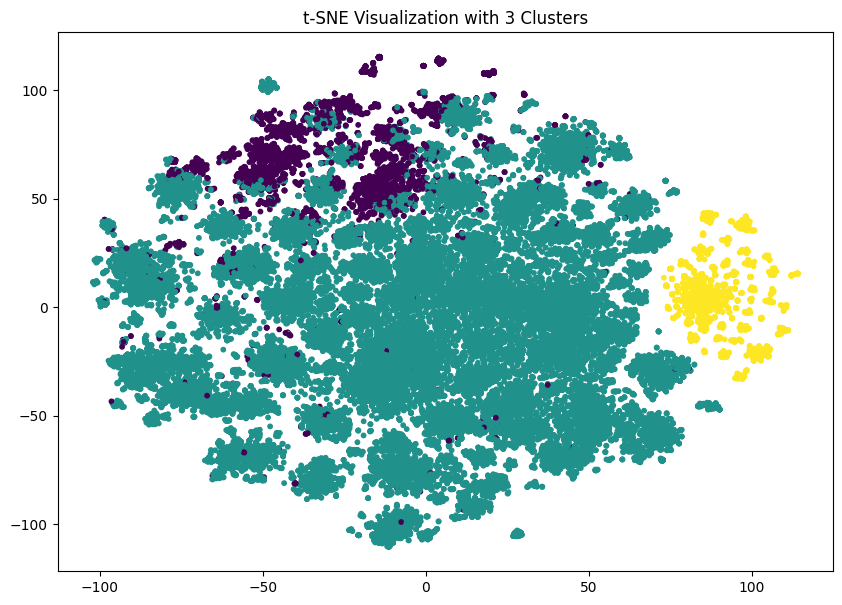

In [13]:
# t-SNE Transformation
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_features = tsne.fit_transform(reduced_features)

# t-SNE Visualization
plt.figure(figsize=(10, 7))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=news['cluster'], cmap='viridis', s=10)
plt.title(f't-SNE Visualization with {optimal_k} Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [14]:
# Print t-SNE parameters
print("t-SNE Parameters:")
print(f"Perplexity: {tsne.perplexity}")
print(f"Number of iterations: {tsne.n_iter}")

# Print size of each cluster in the t-SNE space
print("\nCluster Sizes in t-SNE:")
for i in range(optimal_k):
    print(f"Cluster {i}: {sum(news['cluster'] == i)} points")

t-SNE Parameters:
Perplexity: 30
Number of iterations: deprecated

Cluster Sizes in t-SNE:
Cluster 0: 4581 points
Cluster 1: 43429 points
Cluster 2: 2659 points


# DBSCAN Clustering

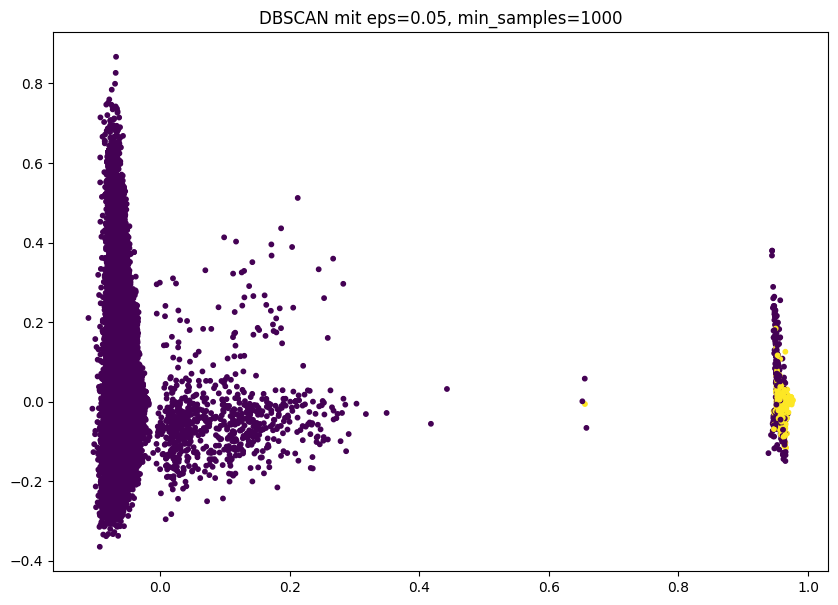

Parameter eps=0.05, min_samples=1000
{np.int64(-1): np.int64(48575), np.int64(0): np.int64(2094)}

----------------------------------------



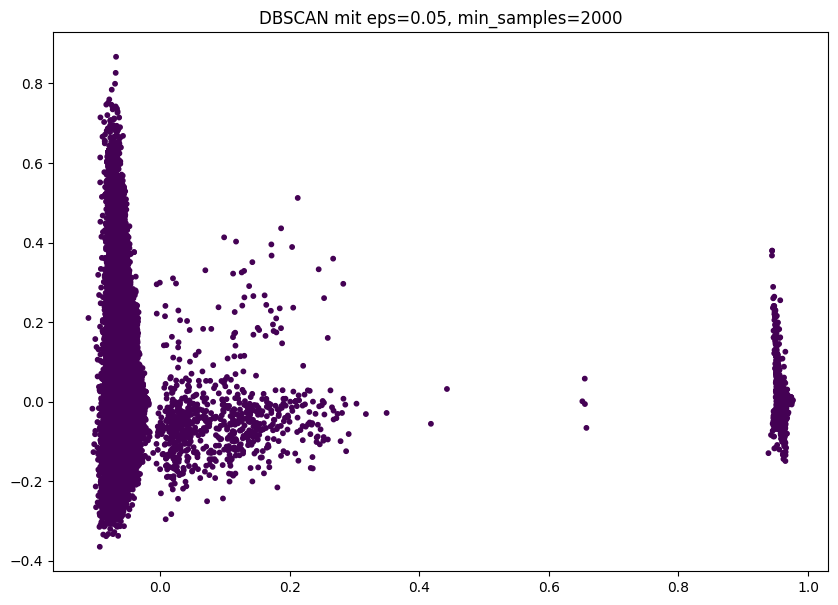

Parameter eps=0.05, min_samples=2000
{np.int64(-1): np.int64(50669)}

----------------------------------------



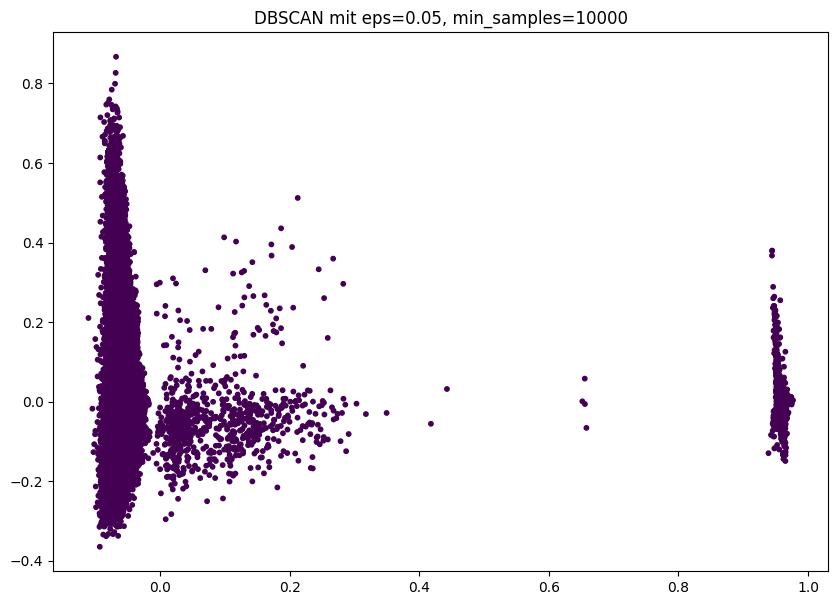

Parameter eps=0.05, min_samples=10000
{np.int64(-1): np.int64(50669)}

----------------------------------------



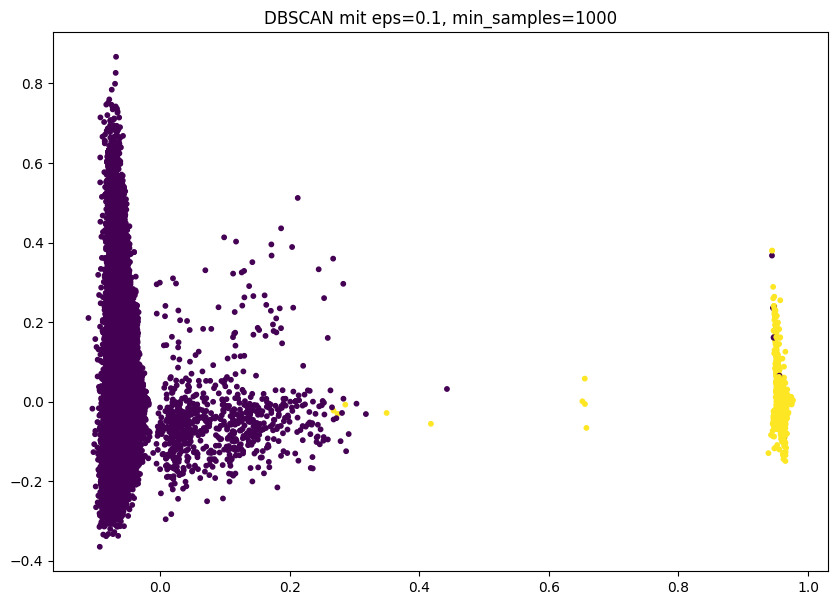

Parameter eps=0.1, min_samples=1000
{np.int64(-1): np.int64(48017), np.int64(0): np.int64(2652)}

----------------------------------------



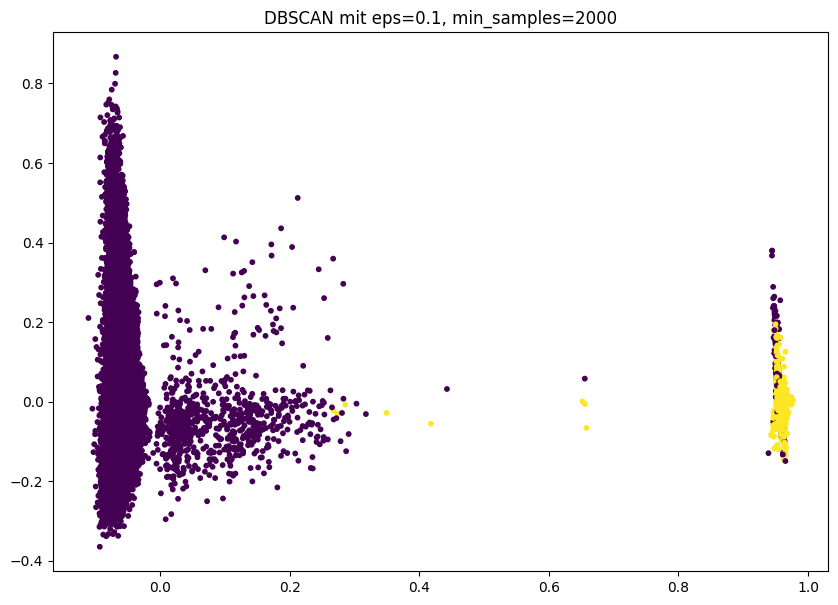

Parameter eps=0.1, min_samples=2000
{np.int64(-1): np.int64(48222), np.int64(0): np.int64(2447)}

----------------------------------------



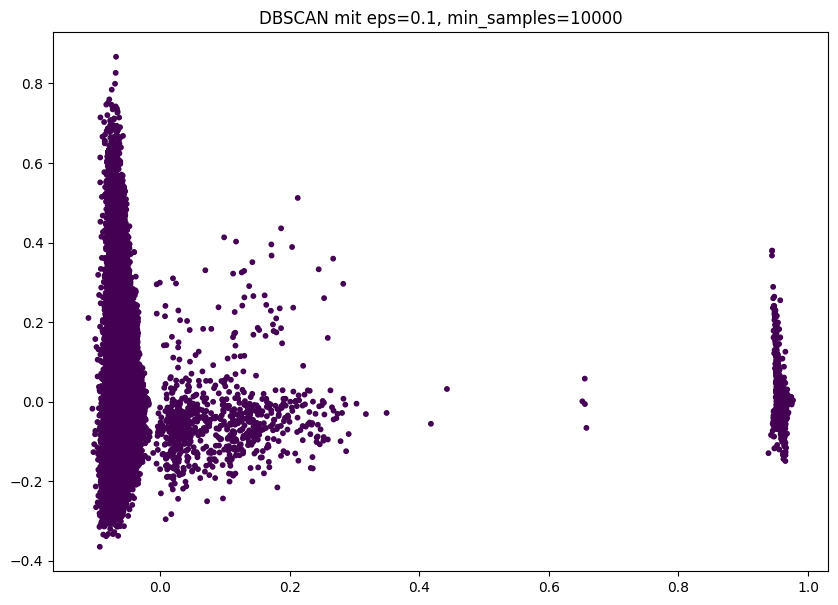

Parameter eps=0.1, min_samples=10000
{np.int64(-1): np.int64(50669)}

----------------------------------------



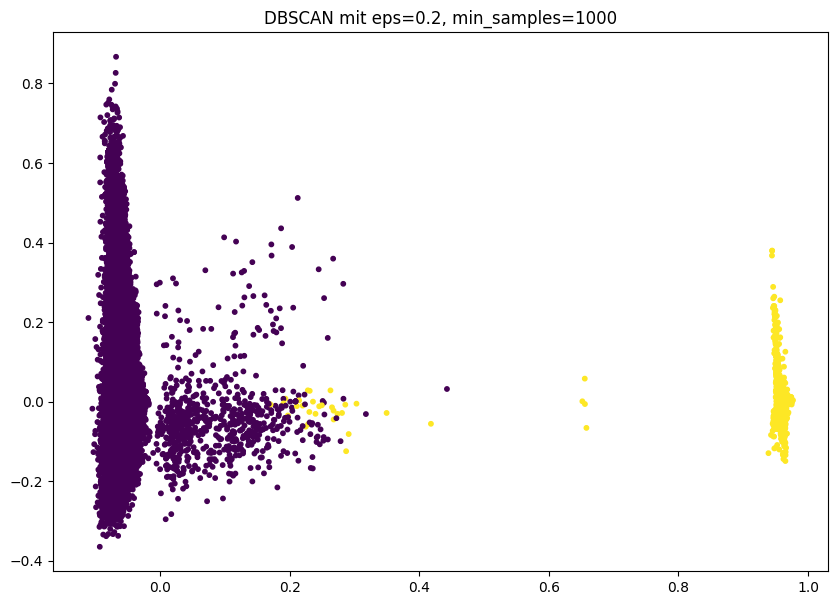

Parameter eps=0.2, min_samples=1000
{np.int64(-1): np.int64(47982), np.int64(0): np.int64(2687)}

----------------------------------------



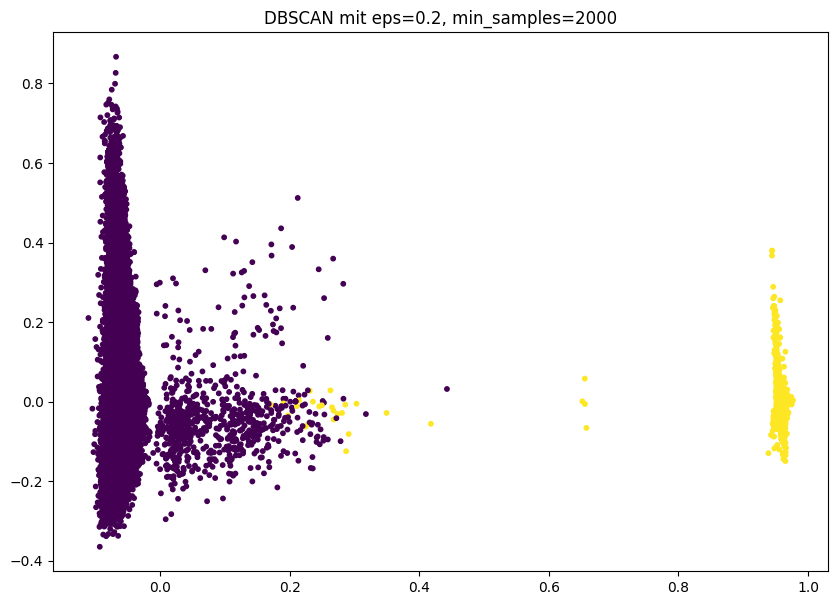

Parameter eps=0.2, min_samples=2000
{np.int64(-1): np.int64(47987), np.int64(0): np.int64(2682)}

----------------------------------------



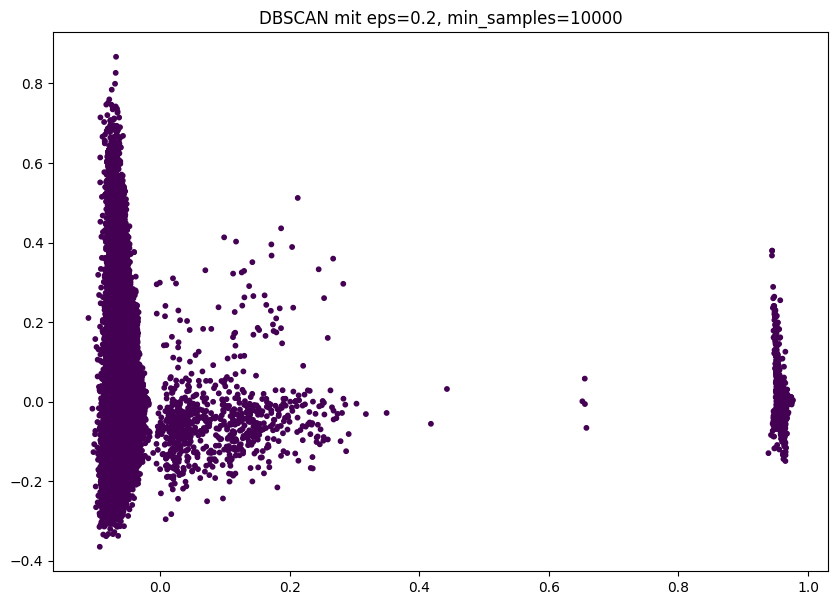

Parameter eps=0.2, min_samples=10000
{np.int64(-1): np.int64(50669)}

----------------------------------------



In [15]:
# DBSCAN Clustering
eps_values = [0.05, 0.1, 0.2]
min_samples_values = [1000, 2000, 10000]

# Small eps values (like 0.05) lead to many small, dense clusters and a high number of outliers, which might be too restrictive for your dataset.
# Medium eps values (e.g., 0.1) offer a better balance and create several larger clusters. This might be a better choice as it results in fewer outliers and more differentiated clusters.
# Large eps values (e.g., 0.2) tend to group most data points into one cluster, indicating that eps=0.2 is too large to form meaningful clusters.

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = dbscan.fit_predict(reduced_features)

        plt.figure(figsize=(10, 7))
        plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
        plt.title(f'DBSCAN mit eps={eps}, min_samples={min_samples}')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()

        unique, counts = np.unique(labels, return_counts=True)
        print(f'Parameter eps={eps}, min_samples={min_samples}')
        print(dict(zip(unique, counts)))
        print("\n" + "-"*40 + "\n")

# Elements an Categories per Clustering

In [16]:
# KMeans

# Count the number of articles in each cluster
cluster_counts = news['cluster'].value_counts().sort_index()

# Initialize dictionaries to store cluster information
cluster_examples = {}
cluster_categories = {}

# Iterate through each cluster
for cluster_id in sorted(news['cluster'].unique()):
    cluster_data = news[news['cluster'] == cluster_id]
    
    # Save 10 example articles (title and category)
    cluster_examples[cluster_id] = cluster_data[['title', 'category']].head(10)
    
    # Count the categories within the cluster
    cluster_categories[cluster_id] = cluster_data['category'].value_counts()

# Print the results
print("Number of articles per cluster:")
print(cluster_counts)

for cluster_id in cluster_examples:
    print(f"\nCluster {cluster_id}:")
    print("Examples:")
    print(cluster_examples[cluster_id])
    print("\nCategories in the cluster:")
    print(cluster_categories[cluster_id])


Number of articles per cluster:
cluster
0     4581
1    43429
2     2659
Name: count, dtype: int64

Cluster 0:
Examples:
                                                title      category
1                       50 Worst Habits For Belly Fat        health
4   How to Get Rid of Skin Tags, According to a De...        health
6   It's been Orlando's hottest October ever so fa...       weather
10  50 Foods You Should Never Eat, According to He...        health
12  25 Biggest Grocery Store Mistakes Making You G...        health
21  17 Abandoned Theme Parks to Explore for Thrill...        travel
25                10 Things You Never Knew About Owls     lifestyle
26  25 Last-Minute Ideas That Will Absolutely Save...  foodanddrink
34  20 Must-Try Gravy Recipes for Your Thanksgivin...  foodanddrink
39  5 Things You Probably Shouldn't Be Buying from...     lifestyle

Categories in the cluster:
category
foodanddrink     839
lifestyle        673
news             673
health           565
finance   

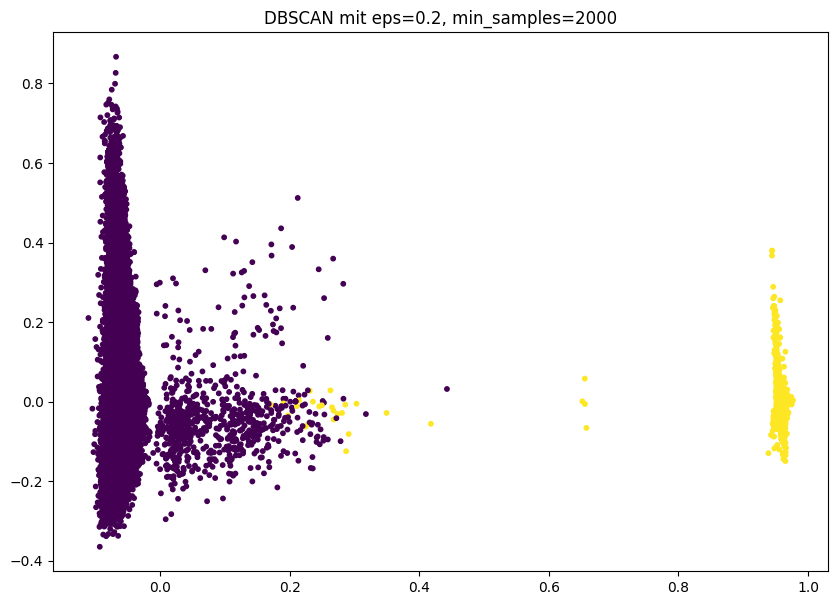

Parameter eps=0.2, min_samples=2000
{np.int64(-1): np.int64(47987), np.int64(0): np.int64(2682)}

----------------------------------------

Number of articles per DBSCAN cluster:
{np.int64(-1): np.int64(47987), np.int64(0): np.int64(2682)}

Cluster -1:
Examples:
                                               title       category
0  The Brands Queen Elizabeth, Prince Charles, an...      lifestyle
1                      50 Worst Habits For Belly Fat         health
2  The Cost of Trump's Aid Freeze in the Trenches...           news
3  I Was An NBA Wife. Here's How It Affected My M...         health
4  How to Get Rid of Skin Tags, According to a De...         health
5  Should NFL be able to fine players for critici...         sports
6  It's been Orlando's hottest October ever so fa...        weather
7  Chile: Three die in supermarket fire amid prot...           news
8  Best PS5 games: top PlayStation 5 titles to lo...  entertainment
9     How to report weather-related closings, delays     

In [17]:
# DBSCAN
best_eps = 0.2
best_samples = 2000


dbscan = DBSCAN(eps= best_eps, min_samples=best_samples, metric='cosine')
labels = dbscan.fit_predict(reduced_features)

plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
plt.title(f'DBSCAN mit eps={best_eps}, min_samples={best_samples}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

unique, counts = np.unique(labels, return_counts=True)
print(f'Parameter eps={best_eps}, min_samples={best_samples}')
print(dict(zip(unique, counts)))
print("\n" + "-"*40 + "\n")


# Count the number of articles in each DBSCAN cluster
unique_labels = np.unique(labels)  # labels = DBSCAN output labels
cluster_counts_dbscan = {label: (labels == label).sum() for label in unique_labels}

# Initialize dictionaries to store cluster information
cluster_examples_dbscan = {}
cluster_categories_dbscan = {}

# Iterate through each DBSCAN cluster
for cluster_id in unique_labels:
    cluster_data = news[labels == cluster_id]
    
    # Save 10 example articles (title and category)
    cluster_examples_dbscan[cluster_id] = cluster_data[['title', 'category']].head(10)
    
    # Count the categories within the cluster
    cluster_categories_dbscan[cluster_id] = cluster_data['category'].value_counts()

# Print the results
print("Number of articles per DBSCAN cluster:")
print(cluster_counts_dbscan)

for cluster_id in cluster_examples_dbscan:
    print(f"\nCluster {cluster_id}:")
    print("Examples:")
    print(cluster_examples_dbscan[cluster_id])
    print("\nCategories in the cluster:")
    print(cluster_categories_dbscan[cluster_id])